In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import expit
from collections import namedtuple
from ipywidgets import IntProgress
# from IPython.display import display

import gpflow
from gpflow.utilities import print_summary, positive

import tensorflow as tf
from tensorflow import math as tfm
from tensorflow_probability import bijectors as tfb
from tensorflow_probability import distributions as tfd
from tensorflow_probability import mcmc
import tensorflow_probability as tfp

import arviz

from load_puma_data import load_barenco_puma
import math
import random
import time

PI = tf.constant(math.pi, dtype='float64')
plt.style.use('ggplot')
%matplotlib inline

In [2]:
df, genes, genes_se, Y, Y_var = load_barenco_puma()


N_m = 7               # Number of observations
def calc_N_p(N_p, num_disc=8):
    '''A helper recursive function to ensure t is a subset of τ'''
    if num_disc <= 0:
        return N_p
    return N_p -1 + calc_N_p(N_p, num_disc-1)
num_disc = 10
N_p = calc_N_p(N_m, num_disc)  # Number of time discretisations
common_indices = np.array([i*num_disc+i for i in range(N_m)])
t = np.arange(N_m)*2           # Observation times
τ = np.linspace(0, 12, N_p, dtype='float64')    # Discretised observation times
num_genes = 5
I = 1 # Number of TFs

m_observed = np.float64(Y[:-1])
f_observed = np.float64(np.atleast_2d(Y[-1]))
σ2 = np.float64(Y_var[:-1])
σ2_f = np.float64(np.atleast_2d(Y_var[-1]))


In [84]:
def get_rbf_dist(times, N):
    t_1 = np.reshape(np.tile(times, N), [N, N]).T
    t_2 = np.reshape(np.tile(times, N), [N, N])
    return t_1-t_2

def jitter_cholesky(A):
    try:
        jitter1 = tf.linalg.diag(1e-7 * np.ones(A.shape[0]))
        return tf.linalg.cholesky(A + jitter1)
    except:
        jitter2 = tf.linalg.diag(1e-5 * np.ones(A.shape[0]))
        return tf.linalg.cholesky(A + jitter2)

def exp(x):
    '''Safe exp'''
    with np.errstate(under='ignore', over='ignore'):
        return np.exp(x)
    
def mult(a, b):
    '''Safe multiplication'''
    with np.errstate(under='ignore', over='ignore', invalid='ignore'):
        c = a*b
        return np.where(np.isnan(c), 0, c)

In [ ]:
class Parameter(tf.Tensor):
    def __init__(self, prior, initial_value, proposal_dist=None, name=None, constraint=None):
        super()
        self.name = name
        self.prior = prior
        self.proposal_dist = proposal_dist
        if constraint is None:
            self.constrained = lambda x:x
        else:
            self.constrained = constraint
        self.value = initial_value

    def set_value(self, value):
        this.value = value
    def constrain(self, *args):
        return self.constrained(*args)
    
    def propose(self, *args):
        assert self.proposal_dist is not None, 'proposal_dist must not be None if you use propose()'
        return self.proposal_dist(*args).sample().numpy()


In [56]:
class TranscriptionLikelihood():
    def predict_m(self, kbar, δbar, w, fbar, w_0):
        # Take relevant parameters out of log-space
        a_j, b_j, d_j, s_j = (np.exp(kbar[:, i]).reshape(-1, 1) for i in range(4))
        δ = np.exp(δbar)
        f_i = np.log(1+np.exp(fbar))
    #     print('f_i', f_i)

        # Calculate p_i vector
        p_i = np.zeros(N_p) # TODO it seems the ODE translation model has params A, S see gpmtfComputeTFODE
        Δ = τ[1]-τ[0]
        sum_term = mult(exp(δ*τ), f_i)
        p_i[1:] = 0.5*Δ*np.cumsum(sum_term[:-1] + sum_term[1:]) # Trapezoid rule
#         try:
        p_i = mult(exp(-δ*τ), p_i)
#         except:
#             print(exp(-δ*τ), p_i)
    #     print('pi', p_i)

        # Calculate m_pred
        integrals = np.zeros((num_genes, N_p))
        interactions = w[:, 0][:, None]*np.log(p_i+1e-100) + w_0
        G = expit(interactions) # TF Activation Function (sigmoid)
        sum_term = G * exp(d_j*τ)
        integrals[:, 1:] = 0.5*Δ*np.cumsum(sum_term[:, :-1] + sum_term[:, 1:], axis=1) # Trapezoid rule
        exp_dt = exp(-d_j*τ)
        integrals = mult(exp_dt, integrals)
        m_pred = b_j/d_j + mult((a_j-b_j/d_j), exp_dt) + s_j*integrals

        return m_pred

    def genes(self, δbar=None,
                    fbar=None, 
                    kbar=None, 
                    w=None,
                    σ2_m=None):
        '''
        Computes likelihood of the genes.
        If any of the optional args are None, they are replaced by their current value in params.
        '''
        if δbar is None:
            δbar = 0.1
        if fbar is None:
            fbar = 0.5*np.ones(N_p)
        # if kbar is None:
        #     kbar = 


        w = np.ones((num_genes, I)) if w is None else w
        σ2_m = 1e-4*np.ones(num_genes) if σ2_m is None else σ2_m

        w_0 = 0 # TODO no hardcode this!
        m_pred = self.predict_m(kbar, δbar, w, fbar, w_0)

        log_lik = np.zeros(num_genes)
        sq_diff = np.square(m_observed - m_pred[:, common_indices])
        variance = σ2_m.reshape(-1, 1) + σ2 # add PUMA variance
        log_lik = -0.5*np.log(2*np.pi*(variance)) - 0.5*sq_diff/variance
        log_lik = np.sum(log_lik, axis=1)

        return log_lik

    def tfs(self, fbar, i=0): 
        '''
        Computes log-likelihood of the transcription factors.
        TODO this should be for the i-th TF
        '''
        f_pred = np.log(1+np.exp(fbar))
        f_pred = np.atleast_2d(f_pred[common_indices])
        sq_diff = np.square(f_observed[i] - f_pred[i])
        log_lik = -0.5*sum(np.log(2*np.pi*σ2_f[i])) - 0.5*sum(sq_diff/σ2_f[i])
        return log_lik

likelihood = TranscriptionLikelihood()
print(likelihood.genes())

[-101.69389069  -47.72393212 -115.63859199  -46.773523    -10.04370232]


In [160]:
f64 = np.float64
class TranscriptionModel():
    def __init__(self):
        a = tf.constant(-0.5, dtype='float64')
        b2 = tf.constant(2., dtype='float64')
        self.h_δ = 0.25
        self.h_c = 0.05
        self.h_f = 0.35*tf.ones(N_p, dtype='float64')
        self.h_k = 0.25*tf.ones(4, dtype='float64')
        self.h_w = 0.5*tf.ones(num_genes, dtype='float64')
        h_σm = tf.constant(0.5, dtype='float64')
        self.t_dist = get_rbf_dist(τ, N_p)

        proposals = [
            lambda mu:tfd.Normal(mu, self.h_δ).sample(), 
            self.f_proposal, 
            lambda mu: tfd.MultivariateNormalDiag(mu, self.h_k).sample()
        ]
        priors = [tfd.Normal(a, b2).log_prob, self.fbar_prior, tfd.Normal(a, b2).log_prob]
        def state_transition(state_parts, seed):
            # print('parts', state_parts)
            next_state_parts = []
            for i, sp in enumerate(state_parts):
                next_state_parts.append(proposals[i](sp))
            # print(next_state_parts)
            return next_state_parts

        def target_log_prob(*args):
            prob = f64(0)
            prob += sum(likelihood.genes(δbar=args[0], fbar=args[1], kbar=args[2]))
            prob += likelihood.tfs(args[1])
            for i, value in enumerate(args):
                prior_log_prob = tf.reduce_sum(priors[i](value))

                prob += prior_log_prob
            print(args)
            print(prob)
            return tf.constant(prob)

        self.rwm = mcmc.RandomWalkMetropolis(
                target_log_prob,
                new_state_fn=state_transition,
                seed=42)

    def f_proposal(self, fbar):
        # Gibbs step
        z_i = tf.reshape(tfd.MultivariateNormalDiag(fbar, self.h_f).sample(), (1, -1))
        # MH
        m, K = self.fbar_prior_params(4, 8) # TODO v, l param
        invKsigmaK = tf.matmul(tf.linalg.inv(K+tf.linalg.diag(self.h_f)), K) # (C_i + hI)C_i
        L = jitter_cholesky(K-tf.matmul(K, invKsigmaK))
        c_mu = tf.matmul(z_i, invKsigmaK)
        fstar = tf.matmul(tf.random.normal((1, L.shape[0]), dtype='float64'), L) + c_mu
        fstar = tf.reshape(fstar, (-1, ))
        return fstar

    def fbar_prior_params(self, v, l2):
    #     print('vl2', v, l2)
        jitter = tf.linalg.diag(1e-5 * np.ones(N_p))
        K = mult(v, exp(-np.square(self.t_dist)/(2*l2))) + jitter
        m = np.zeros(N_p)
        return m, K

    def fbar_prior(self, fbar, v=4, l2=8):
        m, K = self.fbar_prior_params(v, l2)
    
        try:
            return tfd.MultivariateNormalFullCovariance(m, K).log_prob(fbar)
        except:
            jitter = tf.linalg.diag(1e-4 * np.ones(N_p))
            try:
                return np.float64(tfd.MultivariateNormalFullCovariance(m, K+jitter).log_prob(fbar))
            except:
                return 0

model = TranscriptionModel()
initial_fbar = 0.5*tf.ones(N_p, dtype='float64')

print(model.rwm.target_log_prob_fn(*[tf.constant(f64(-0.3)), initial_fbar, initial_kbar]))

(<tf.Tensor: shape=(), dtype=float64, numpy=-0.3>, <tf.Tensor: shape=(67,), dtype=float64, numpy=
array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5])>, array([[-0.1, -0.1, -0.1, -0.1],
       [-0.1, -0.1, -0.1, -0.1],
       [-0.1, -0.1, -0.1, -0.1],
       [-0.1, -0.1, -0.1, -0.1],
       [-0.1, -0.1, -0.1, -0.1]]))
tf.Tensor(-103.06017797037264, shape=(), dtype=float64)
tf.Tensor(-103.06017797037264, shape=(), dtype=float64)


In [161]:
num_burnin_steps = 5
num_chain_results = 100

initial_kbar = -0.1*np.float64(np.c_[
    np.ones(num_genes), # a_j
    np.ones(num_genes), # b_j
    np.ones(num_genes), # d_j
    np.ones(num_genes)  # s_j
])
initial_fbar = 0.5*tf.ones(N_p, dtype='float64')

samples, _ = mcmc.sample_chain(
    num_results=num_chain_results,
    num_burnin_steps=num_burnin_steps,
    current_state=[tf.constant(f64(-0.3)), initial_fbar, initial_kbar],
    kernel=model.rwm,
    parallel_iterations=1)  # For determinism.

# print(samples)
# sample_mean = tf.math.reduce_mean(samples, axis=0)
# sample_std = tf.sqrt(
#     tf.math.reduce_mean(
#         tf.math.squared_difference(samples, sample_mean),
#         axis=0))
# print('Estimated mean: {}'.format(sample_mean))
# print('Estimated standard deviation: {}'.format(sample_std))


(<tf.Tensor: shape=(), dtype=float64, numpy=-0.3>, <tf.Tensor: shape=(67,), dtype=float64, numpy=
array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5])>, <tf.Tensor: shape=(5, 4), dtype=float64, numpy=
array([[-0.1, -0.1, -0.1, -0.1],
       [-0.1, -0.1, -0.1, -0.1],
       [-0.1, -0.1, -0.1, -0.1],
       [-0.1, -0.1, -0.1, -0.1],
       [-0.1, -0.1, -0.1, -0.1]])>)
tf.Tensor(-103.06017797037264, shape=(), dtype=float64)
(<tf.Tensor: shape=(), dtype=float64, numpy=-0.09297638305923894>, <tf.Tensor: shape=(67,), dtype=float64, numpy=
array([0.66958301, 0.17526071, 0.55910076, 0.61735303, 0.6182268 ,
       0.61313347, 0.63398404, 0.64079536, 0.64316458, 0.63343525,
  

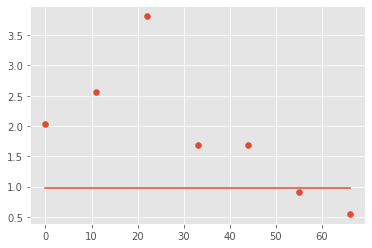

In [162]:
f = np.log(1+np.exp(samples[1][-1]))
plt.plot(f)
plt.scatter(np.arange(N_p)[common_indices], f_observed[0])